On perlmutter: use kernel pytorch-1.13.1

In [1]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: radha-mastandrea (rmastand). Use `wandb login --relogin` to force relogin


True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
from scipy.stats import wasserstein_distance

import os
import torch

from numba import cuda 

from helpers.make_flow import *
from helpers.make_BC import *
from helpers.train_BC import *
from helpers.plotting import *
from helpers.evaluation import *

seed = 8

In [3]:
# computing

device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(32)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cuda


SBL data has shape (332348, 7).
IBL data has shape (36411, 7).
SR data has shape (45818, 7).
IBH data has shape (14290, 7).
SBH data has shape (63023, 7).


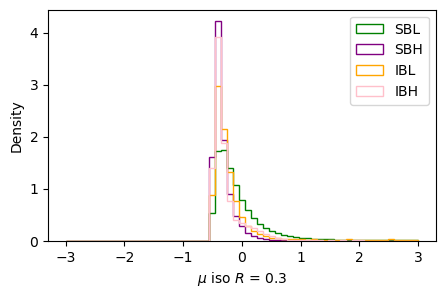

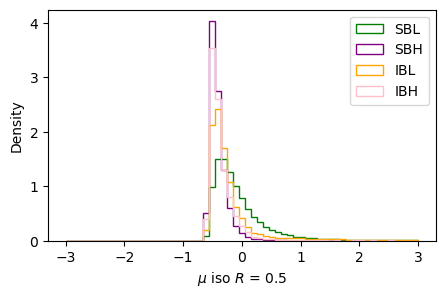

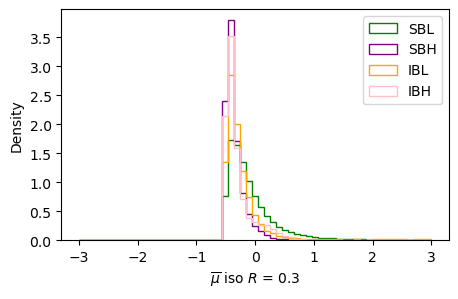

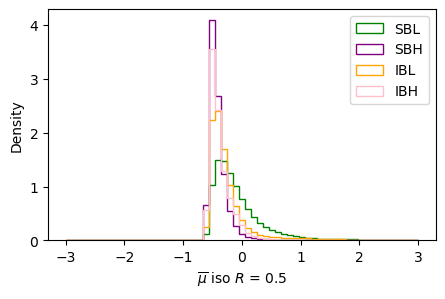

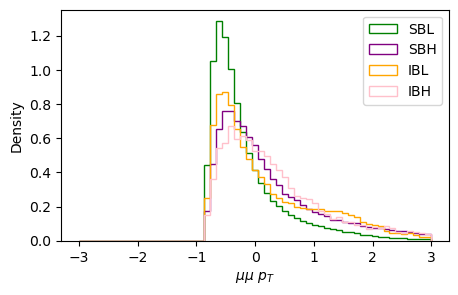

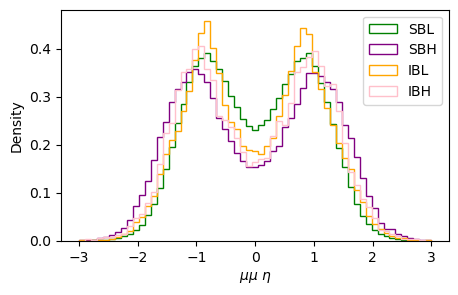

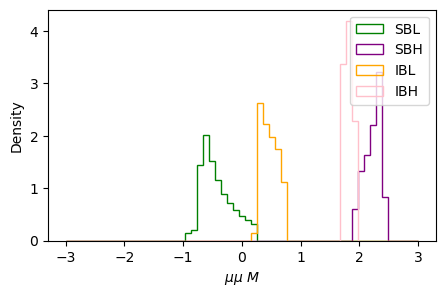

In [4]:
# load in the data

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}

feature_set = [5, 6, 7, 8, 9, 10, 12]
num_features = len(feature_set) - 1 # context doesn't count

for b in bands:

    data_dict[b] = np.load(f"processed_data/cmssim_{b}_minmax.npy")[:,feature_set]
    print("{b} data has shape {length}.".format(b = b, length = data_dict[b].shape))


data_dict["SB"] =  np.vstack((data_dict["SBL"], data_dict["SBH"]))
data_dict["IB"] =  np.vstack((data_dict["IBL"], data_dict["IBH"]))


hist_all_features(["SBL", "SBH", "IBL", "IBH"], data_dict, feature_set, kwargs_dict_bands, scaled_features = True, image_path = "plots/procc_data")


In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'bc_discrim_IB',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'num_layers': {
        'values': [1, 2, 4]
        },
    'num_hidden_features': {
        'values': [16, 32, 64, 128]
        },
    'num_blocks': {
        'values': [2, 4, 1]
        },
    'learning_rate': {
          'values': [0.0001, 0.0005, 0.001]
        },
    'weight_decay': {
          'values': [0]
        },
    'batch_size': {
          'values': [128, 256, 512, 1024]
        },
    'epochs': {
          'values': [50]
        },
    'flow_type': {
          'values': ["AR", "coupling"]
        },
    }

sweep_config['parameters'] = parameters_dict

sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-OD3")


## Flow creation and training

In [ ]:
def build_dataset(batch_size):
    
    SB1_train_dataset, SB1_val_dataset = train_test_split(data_dict["SBL"], test_size=0.2, random_state=seed)
    SB2_train_dataset, SB2_val_dataset = train_test_split(data_dict["SBH"], test_size=0.2, random_state=seed)

    print(f"SBL train data has shape {SB1_train_dataset.shape}.")
    print(f"SBL val data has shape {SB1_val_dataset.shape}.")
    print(f"SBH train data has shape {SB2_train_dataset.shape}.")
    print(f"SBH val data has shape {SB2_val_dataset.shape}.")
    print()
    
    # calculate the weights for the train and val datasets
    weight_SB1_train = 1. / SB1_train_dataset.shape[0]
    weight_SB1_val = 1. / SB1_val_dataset.shape[0]
    weight_SB2_train = 1. / SB2_train_dataset.shape[0]
    weight_SB2_val = 1. / SB2_val_dataset.shape[0]
        
    weights_train = [weight_SB1_train for i in range(SB1_train_dataset.shape[0])] + [weight_SB2_train for i in range(SB2_train_dataset.shape[0])]
    weights_val = [weight_SB1_val for i in range(SB1_val_dataset.shape[0])] + [weight_SB2_val for i in range(SB2_val_dataset.shape[0])]
    
    sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weights_train, len(weights_train))
    sampler_val = torch.utils.data.sampler.WeightedRandomSampler(weights_val, len(weights_val))

    train_dataset = np.vstack((SB1_train_dataset, SB2_train_dataset))    
    val_dataset = np.vstack((SB1_val_dataset, SB2_val_dataset))

    train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = 8, pin_memory = True, sampler = sampler_train)
    val_data = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers = 8, sampler = sampler_val)

    return train_data, val_data
    
    
    
def build_flow(num_features, num_layers, num_hidden_features, num_blocks, flow_type):
    
    if flow_type == "AR":
        flow = make_masked_AR_flow(num_features, num_layers, num_hidden_features, num_blocks)
    elif flow_type == "coupling":
        flow = make_coupling_flow(num_features, num_layers, num_hidden_features, num_blocks)

    pytorch_total_params = sum(p.numel() for p in flow.parameters() if p.requires_grad)
    print(f"Numb. trainable params: {pytorch_total_params}")
    
    return flow
    

def build_optimizer(flow, learning_rate, weight_decay, epochs):
    
    optimizer = optim.AdamW(flow.parameters(), lr = learning_rate, 
                            weight_decay = weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min = 0)
    
    return optimizer, scheduler

def evaluate_one_epoch(data, flow, optimizer, scheduler, train = True):
    losses_batch_per_e = []     
    for batch_ndx, data in enumerate(data):
        data = data.to(device)
        feats = data[:,:-1].float()
        cont = torch.reshape(data[:,-1], (-1, 1)).float()
        
        if train:
            optimizer.zero_grad()
            
        loss = -flow.log_prob(inputs=feats, context = cont).nanmean()  
        
        if train:
            loss.backward()
            optimizer.step()  
            scheduler.step()
        
        losses_batch_per_e.append(loss.detach().cpu().numpy())
    
    return np.nanmean(losses_batch_per_e)


In [ ]:


def train(config=None):
    
    early_stop = True
    # set seeds
    torch.manual_seed(seed)
    np.random.seed(seed)

    val_loss_to_beat = 1e10

    hyperparameters_dict_BC = {"n_epochs":100,
                              "batch_size": 512,
                              "lr": 0.001,
                             }
    n_runs = 2

    
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        
        train_data, val_data = build_dataset(config.batch_size)
        flow  = build_flow(num_features, config.num_layers, config.num_hidden_features, config.num_blocks, config.flow_type)
        flow.to(device)
        optimizer, scheduler = build_optimizer(flow, config.learning_rate, config.weight_decay, config.epochs)
        if early_stop:
            early_stopping = EarlyStopping(patience = 5)
            
        # TRAIN THE FLOW
        print("Training flow...")

        for epoch in range(config.epochs):
            
            train_loss = evaluate_one_epoch(train_data, flow, optimizer, scheduler, train = True)
            wandb.log({"train_loss": train_loss, "epoch": epoch})    
            
            val_loss = evaluate_one_epoch(val_data, flow, optimizer, scheduler, train = False)
            wandb.log({"val_loss": val_loss, "epoch": epoch})    
            
            #print(f"   On epoch {epoch}. Loss: {train_loss}, Val loss: {val_loss}.")
        
            # see if the model has the best val loss
            if val_loss < val_loss_to_beat:
                val_loss_to_beat = val_loss
                # save the model
                model_path = f"models/best_model.pt"
                torch.save(flow, model_path)

            if early_stop:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print(f"Done training flow! Best val loss at epoch {epoch}.")
                    print()
                    break
                    
        # EVALUATE THE FLOW IN SB
        print("Evaluating flow in SB...")

        data_dict["SBL_samples"] = sample_from_flow(model_path, device, data_dict["SBL"][:,-1], num_features)
        data_dict["SBH_samples"] = sample_from_flow(model_path, device, data_dict["SBH"][:,-1], num_features)
        data_dict["SB_samples"] =  np.vstack((data_dict["SBL_samples"], data_dict["SBH_samples"]))
        
        hist_all_features(["SBL", "SBL_samples"], data_dict, feature_set, kwargs_dict_bands, scaled_features = True, image_path = "plots/low_SB")
        hist_all_features(["SBH", "SBH_samples"], data_dict, feature_set, kwargs_dict_bands, scaled_features = True, image_path = "plots/high_SB")

        # Train a BC to discrim SB data from SB samples
        """
        SB_data_train, SB_data_test, SB_samples_train, SB_samples_test = train_test_split(data_dict["SB"], data_dict["SB_samples"], 
                                                                                      test_size=0.15, random_state=seed)
        auc_list = []
        for i in range(n_runs):
            auc, fpr, tpr, outputs = discriminate_datasets_kfold("models/", SB_data_train[:,:-1],  SB_samples_train[:,:-1], 
                                np.ones((SB_data_train.shape[0],1)), np.ones((SB_samples_train.shape[0],1)), 
                                   SB_data_test[:,:-1], SB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 2, verbose = False)
            auc_list.append(auc)
        print(auc_list)
        wandb.log({"bc_discrim_SB": np.mean(auc_list),})   
        """
        wds = get_1d_wasserstein_distances(data_dict["SB"], data_dict["SB_samples"])
        wandb.log({"bc_discrim_SB": np.mean(wds),})   
        
        
        # EVALUATE THE FLOW IN IB
        print("Evaluating flow in IB...")
        
        data_dict["IBL_samples"] = sample_from_flow(model_path, device, data_dict["IBL"][:,-1], num_features)
        data_dict["IBH_samples"] = sample_from_flow(model_path, device, data_dict["IBH"][:,-1], num_features)
        data_dict["IB_samples"] =  np.vstack((data_dict["IBL_samples"], data_dict["IBH_samples"]))
        
        hist_all_features(["IBL", "IBL_samples"], data_dict, feature_set, kwargs_dict_bands, scaled_features = True, image_path = "plots/low_IB", plot_bound = 2.5)
        hist_all_features(["IBH", "IBH_samples"], data_dict, feature_set, kwargs_dict_bands, scaled_features = True, image_path = "plots/high_IB", plot_bound = 2.5)

        """
        IB_data_train, IB_data_test, IB_samples_train, IB_samples_test = train_test_split(data_dict["IB"], data_dict["IB_samples"], 
                                                                                  test_size=0.15, random_state=seed)
 
        auc_list = []
        for i in range(n_runs):
            auc, fpr, tpr, outputs = discriminate_datasets_kfold("models/", IB_data_train[:,:-1],  IB_samples_train[:,:-1], 
                                np.ones((IB_data_train.shape[0],1)), np.ones((IB_samples_train.shape[0],1)), 
                                   IB_data_test[:,:-1], IB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 3, verbose = False)
            auc_list.append(auc)
        wandb.log({"bc_discrim_IB": np.mean(auc_list),})    
        """
         wds = get_1d_wasserstein_distances(data_dict["IB"], data_dict["IB_samples"])
        wandb.log({"bc_discrim_SB": np.mean(wds),})   
        
        print("All done!")


In [ ]:
wandb.agent(sweep_id, train, count=30)
